# OPNFV VSPERF
# Beyond Performance Metrics: Towards Causation Analysis

### sridhar.rao@spirent.com and acm@research.att.com

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
import collections
import glob
import os

## Get the results to analyze: 
Getting Latest one, if ``directory_to_download`` is empty

In [ ]:
import paramiko
import tarfile
import os
from stat import S_ISDIR
RECV_BYTES = 4096
hostname = '10.10.120.24'
port = 22
uname='opnfv'
pwd='opnfv' 
stdout_data = []
stderr_data = []
client = paramiko.Transport((hostname, port))
client.connect(username=uname, password=pwd)
session = client.open_channel(kind='session')
directory_to_download = ''

session.exec_command('ls /tmp | grep results')
if not directory_to_download:
    while True:
        if session.recv_ready():
            stdout_data.append(session.recv(RECV_BYTES))
        if session.recv_stderr_ready():
            stderr_data.append(session.recv_stderr(RECV_BYTES))
        if session.exit_status_ready():
            break
    if stdout_data:
        line = stdout_data[0]
        filenames = line.decode("utf-8").rstrip('\n').split('\n')
        filenames = sorted(filenames)
        latest = filenames[-1]
        directory_to_download = os.path.join('/tmp', latest).replace("\\","/")
        print(directory_to_download)
stdout_data = []
stderr_data = []
# session.close()
if directory_to_download:
    # zip the collectd results to make the download faster
    zip_command = 'sudo -S tar -czvf '+ directory_to_download + '/collectd.tar.gz -C ' + directory_to_download + '/csv .'
    session = client.open_channel(kind='session')
    session.get_pty()
    session.exec_command(zip_command)
    while True:
        if session.recv_ready():
            stdout_data.append(session.recv(RECV_BYTES))
        if session.recv_stderr_ready():
            stderr_data.append(session.recv_stderr(RECV_BYTES))
        if session.exit_status_ready():
            break
    if stderr_data:
        print(stderr_data[0])
    if stdout_data:
        print(stdout_data[0])

    # Begin the actual downlaod
    sftp = paramiko.SFTPClient.from_transport(client)
    def sftp_walk(remotepath):
        # print(remotepath)
        path=remotepath
        files=[]
        folders=[]
        for f in sftp.listdir_attr(remotepath):
            # print(f.filename)
            if S_ISDIR(f.st_mode):
                folders.append(f.filename)
            else:
                files.append(f.filename)
        if files:
            yield path, files
    # Filewise download happens here
    for path,files  in sftp_walk(directory_to_download):
        for file in files:
            remote = os.path.join(path,file).replace("\\","/")
            local = os.path.join('./results', file).replace("\/","/")
            # print(remote)
            # print(local)
            sftp.get(remote, local)
# Untar the collectd results if we got it.
path = os.path.join('./results', 'collectd.tar.gz')
if os.path.exists(path):
    tar = tarfile.open(path)
    tar.extractall()
    tar.close()
# Ready to work with downloaded data, close the session and client.
session.close()
client.close()

In [2]:
strings = ('* OS:', '* Kernel Version:', '* Board:', '* CPU:', '* CPU cores:',
           '* Memory:', '* Virtual Switch Set-up:',
           '* Traffic Generator:','* vSwitch:', '* DPDK Version:', '* VNF:')
filename = os.path.basename(glob.glob('./results/result*.rst')[0])
info_dict = {}
with open(os.path.join('./results', filename), 'r') as file:
    for line in file:
        if any(s in line for s in strings):
            info_dict[line.split(':', 1)[0]] = line.split(':', 1)[1].rstrip()
df = pd.DataFrame.from_dict(info_dict, orient='index', columns=['Value'])
df

Value
* OS                                                   CentOS Linux 7 Core
* Kernel Version                               4.4.116-1.el7.elrepo.x86_64
* Board                            Intel Corporation S2600WT2R [2 sockets]
* CPU                            Intel(R) Xeon(R) CPU E5-2699 v4 @ 2.20GHz
* CPU cores                                                             44
* Memory                                                       65917716 kB
* Virtual Switch Set-up                                                pvp
* Traffic Generator       Trex, Version: v2.38, GIT tag: dc557baa2deb27...
* vSwitch                 OvsDpdkVhost, Version: 2.8.1, GIT tag: 5c67e9...
* DPDK Version            17.08.0, GIT tag: 02657b4adcb8af773e26ec061b0...
* VNF                     QemuDpdkVhostUser, Version: 2.9.1, GIT tag: 4...

## Understand the configuration used for the test.

In [3]:
filename = os.path.basename(glob.glob('./results/vsperf*.conf')[0])
file = os.path.join('./results', filename)
with open(file, 'r') as f:
    for line in f:
        if line.startswith('TRAFFICGEN_DURATION'):
            value = line.split('=')[1]
            value = value.rstrip()
            value = value.lstrip()
            traffic_duration = int(value)
        elif line.startswith('VSWITCH_PMD_CPU_MASK'):
            value = line.split('=')[1]
            value = value.rstrip()
            pmd_cores_mask = value.lstrip()
        elif line.startswith('GUEST_CORE_BINDING'):
            value = line.split('=')[1]
            value = value.rstrip()
            value = value.lstrip()
            guest_cores = value[1:-2]

print(traffic_duration)
print(pmd_cores_mask)
print(guest_cores)

60
'F0'
['8','22']


## OVS-Ports and Cores

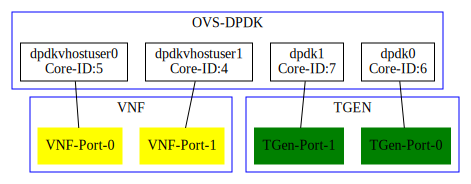

In [4]:
import collections
portcores = collections.OrderedDict()
chunks = []
current_chunk = []
file = os.path.join('./results', 'ovs-cores.log')
with open(file, 'r') as f:
    for line in f:
        if line.startswith('pmd') and current_chunk:
            # if line starts with token and the current chunk is not empty
            chunks.append(current_chunk[:]) #  add not empty chunk to chunks
            current_chunk = [] #  make current chunk blank
        # just append a line to the current chunk on each iteration
        if "port:" in line or 'pmd' in line:
            current_chunk.append(line)
    chunks.append(current_chunk)  #  append the last chunk outside the loop

core_ids = []
for ch in chunks:
    port_id = ''
    core_id = ''
    for line in ch:
        if 'pmd' in line:
            core_id = line.split()[-1][:-1]
            if core_id not in core_ids:
                core_ids.append(core_id)
        elif 'port:' in line:
            port_id = line.split()[1]
        if port_id and core_id:
            if port_id not in portcores:
                portcores[port_id] = core_id

# import graphviz
from graphviz import Digraph
ps = Digraph(name='ovs-ports-cores', node_attr={'shape': 'box'}, edge_attr={'arrowhead':"none"})
with ps.subgraph(name="cluster_0") as c:
    c.node_attr.update(style='filled', color='green')
    c.node('t0', 'TGen-Port-0')
    c.node('t1', 'TGen-Port-1')
    c.attr(label='TGEN')
    c.attr(color='blue')
with ps.subgraph(name="cluster_1") as c:
    c.node_attr.update(style='filled', color='yellow')
    c.node('v0', 'VNF-Port-0')
    c.node('v1', 'VNF-Port-1')
    c.attr(label='VNF')
    c.attr(color='blue')
    
with ps.subgraph(name='cluster_2') as c: 
    c.attr(label='OVS-DPDK')
    c.attr(color='blue')
    count = 0
    for port, core in portcores.items():
        id = 'o'+str(count)
        c.node(id, port+'\nCore-ID:'+ core)
        count += 1
        num = port[-1]
        if 'dpdkvhost' in port:
            ps.edge(id, 'v'+num)
        else:
            ps.edge(id, 't'+num)

ps

## Dropped Packets

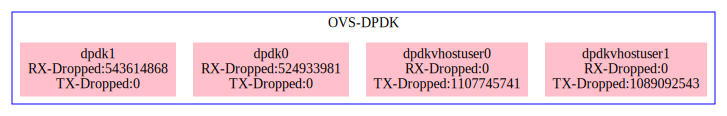

In [5]:
portcores = collections.OrderedDict()
chunks = []
current_chunk = []
file = os.path.join('./results', 'ovs-cores.log')
with open(file, 'r') as f:
    for line in f:
        if line.startswith('pmd') and current_chunk:
            # if line starts with token and the current chunk is not empty
            chunks.append(current_chunk[:]) #  add not empty chunk to chunks
            current_chunk = [] #  make current chunk blank
        # just append a line to the current chunk on each iteration
        if "port:" in line or 'pmd' in line:
            current_chunk.append(line)
    chunks.append(current_chunk)  #  append the last chunk outside the loop

core_ids = []
for ch in chunks:
    port_id = ''
    core_id = ''
    for line in ch:
        if 'pmd' in line:
            core_id = line.split()[-1][:-1]
            if core_id not in core_ids:
                core_ids.append(core_id)
        elif 'port:' in line:
            port_id = line.split()[1]
        if port_id and core_id:
            if port_id not in portcores:
                portcores[port_id] = core_id

ps = Digraph(name='ovs-dropped', node_attr={'shape': 'box'}, edge_attr={'arrowhead':"none"})

def get_dropped(port_id):
    # port_id = 'dpdk0'
    if glob.glob('./pod12-node4/*'+port_id):
        dirname = os.path.basename(glob.glob('./pod12-node4/*'+port_id)[0])
        if dirname:
            if glob.glob('./pod12-node4/'+dirname+ '/*dropped*'):
                filename = os.path.basename(glob.glob('./pod12-node4/'+dirname+ '/*dropped*')[0])
                if filename:
                    with open(os.path.join('./pod12-node4', dirname, filename), 'r') as f:
                        line = f.readlines()[-1]
                        fields = line.split(',')
                        return fields[1], fields[2]
    return 'NA','NA'

with ps.subgraph(name="cluster_0") as c:
    c.node_attr.update(style='filled', color='pink')
    c.attr(label='OVS-DPDK')
    c.attr(color='blue')
    count = 0
    for port, core in portcores.items():
        id = 'o'+str(count)
        rx,tx = get_dropped(port)
        c.node(id, port+'\nRX-Dropped:'+ rx + '\nTX-Dropped:' + tx)
        count += 1
        num = port[-1]
ps

## Plotting Live Results - T-Rex

Index(['ts', 'rx_port', 'tx_port', 'rx_pkts', 'tx_pkts', 'rx_pps', 'tx_pps',
       'rx_bps_num', 'rx_bps_den', 'tx_bps_num', 'tx_bps_den'],
      dtype='object')


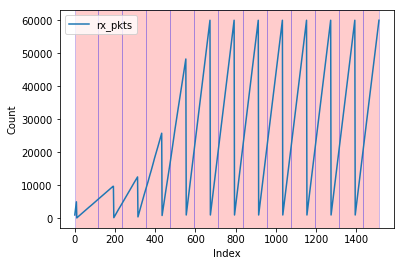

In [6]:
lines_seen = set() # holds lines already seen
outfile = open('./counts.dat', "w")
file = os.path.join('./results', 'trex-liveresults-counts.dat')
for line in open(file, "r"):
    if line not in lines_seen: # not a duplicate
        outfile.write(line)
        lines_seen.add(line)
outfile.close()
tdf = pd.read_csv('./counts.dat')
#tdf.drop_duplicates(inplace=True)
print(tdf.columns)
# ax = tdf.loc[(tdf.rx_port == 1)].plot(x='ts', y='rx_pkts', fontsize=10)
ax = tdf.loc[(tdf.rx_port == 1)].plot(y='rx_pkts')
def highlight(indices,ax):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i][0], indices[i][1], facecolor='RED', edgecolor='BLUE', alpha=.2)
        i+=1

ind = 0
indv = tdf.ts[0]
ax.set_xlabel("Index")
ax.set_ylabel('Count')
for i in range(len(tdf.ts)):
    if tdf.ts[i] - indv > int(traffic_duration):
        highlight([(ind, i)], ax)
        ind = i
        indv = tdf.ts[i]
highlight([(ind,i)], ax)

## IRQ Latency Histogram

Text(0, 0.5, 'Count')

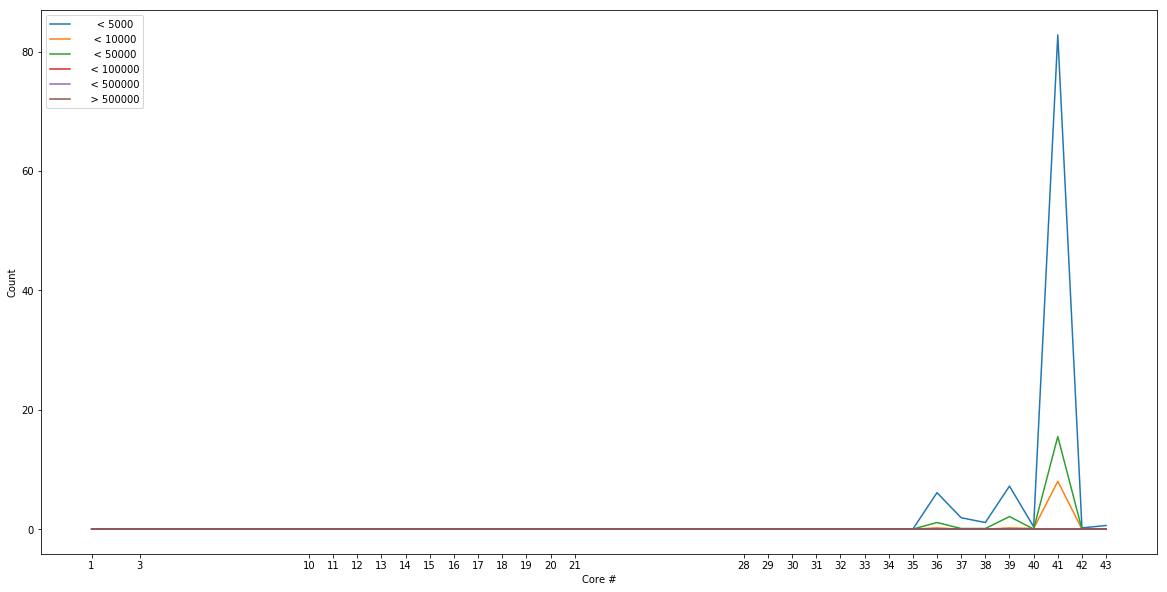

In [7]:
#tdf = pd.read_csv('./test.log')

file = os.path.join('./results', 'RUNirq.irq.log')
tdf = pd.read_csv(file)
tdf.columns
exclude = ['          <1', '         < 5', '        < 10','        < 50', '       < 100', '       < 500', '      < 1000']
ax = tdf.loc[:, tdf.columns.difference(exclude)].plot(x='      number', xticks=tdf['      number'], figsize=(20,10))
ax.set_xlabel('Core #')
ax.set_ylabel('Count')
#tdf.plot(x='number')

## Sample Collectd Metric Display - L3 Cache Occupancy in Bytes

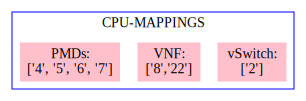

In [8]:
import math
def cpumask2coreids(mask):
    intmask = int(mask, 16)
    i = 1
    coreids = []
    while (i < intmask):
        if (i & intmask):
            coreids.append(str(math.frexp(i)[-1]-1))
        i = i << 1
    return (coreids)

vswitch_cpus = "['2']"
ps = Digraph(name='cpu-map', node_attr={'shape': 'box'}, edge_attr={'arrowhead':"none"})
with ps.subgraph(name="cluster_0") as c:
    c.node_attr.update(style='filled', color='pink')
    c.attr(label='CPU-MAPPINGS')
    c.attr(color='blue')
    c.node('vscpus', 'vSwitch: \n' + vswitch_cpus)
    # vnf_cpus = cpumask2coreids(guest_cores)
    c.node('vncpus', 'VNF: \n' + guest_cores)
    pmd_cpus = cpumask2coreids(pmd_cores_mask[1:-1])
    c.node('pmcpus', 'PMDs: \n' + str(pmd_cpus))

ps

Text(0.5, 0, 'Time')

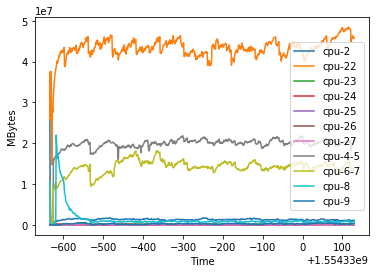

In [9]:
# Path where collectd results are stored.
mypath = "./pod12-node4"
file_count = 0
cpu_names = []
for level1 in os.listdir(mypath):
    if "intel_rdt" in level1:
        l2path = os.path.join(mypath, level1)
        # print(l2path)
        for level2 in os.listdir(l2path):
            if "bytes" in level2:
                l3path = os.path.join(l2path, level2)
                # print(l3path)
                if file_count == 0:
                    file_count += 1
                    df = pd.read_csv(l3path)
                    nn = 'cpu-'+ level1[len('intel_rdt-'):]
                    # nn = 'cpu-'+ level1.split('-')[1]
                    cpu_names.append(nn)
                    # print(nn)
                    df.rename(columns={'value': nn}, inplace=True)
                    # print(df[nn])
                else:
                    file_count += 1
                    tdf = pd.read_csv(l3path)
                    nn = 'cpu-'+ level1[len('intel_rdt-'):]
                    # nn = 'cpu-'+ level1.split('-')[1]
                    cpu_names.append(nn)
                    # print(nn)
                    tdf.rename(columns={'value': nn}, inplace=True)
                    # print(tdf.columns)
                    df[nn] = tdf[nn]            

ax = df.plot(x='epoch', y=cpu_names)
ax.set_ylabel("MBytes")
ax.set_xlabel('Time')


        
#    df = pd.read_csv()

## Events 

In [10]:
from datetime import datetime
filename = os.path.basename(glob.glob('./results/vsperf-overall*.log')[0])
logfile = os.path.join('./results', filename)
linecnt = 0
times = {}
with open(logfile) as f:
    for line in f:
        line = line.strip('\n')
        if linecnt == 0:
            times['Start-Test'] = line.split(" : ")[0]
            linecnt += 1
        if 'Binding NICs' in line:
            times['Binding-NICs'] = line.split(" : ")[0]
        if 'Starting traffic at' in line:
            sline = line.split(" : ")[1]
            time = line.split(" : ")[0]
            speed = sline.split('at',1)[1]
            times[speed] = time 
        elif 'Starting vswitchd' in line:
            times['vSwitch-Start'] = line.split(" : ")[0]
        elif 'Starting ovs-vswitchd' in line:
            times['ovsvswitch-start'] = line.split(" : ")[0]
        elif 'Adding Ports' in line:
            times['Ports-Added'] = line.split(" : ")[0]
        elif 'Flows Added' in line:
            times['Flows-Added'] = line.split(" : ")[0]
        elif 'send_traffic with' in line:
            times['Traffic Start']  = line.split(" : ")[0]
        elif 'l2 framesize 1280' in line:
            times['Traffic-Start-1280'] = line.split(" : ")[0]
        elif 'Starting qemu' in line:
            times['VNF-Start'] = line.split(" : ")[0]
        elif 'l2 framesize 64' in line:
            times['Traffic-Start-64'] = line.split(" : ")[0]
        elif 'l2 framesize 128' in line:
            times['Traffic-Start-128'] = line.split(" : ")[0]
        elif 'l2 framesize 256' in line:
            times['Traffic-Start-256'] = line.split(" : ")[0]
        elif 'l2 framesize 512' in line:
            times['Traffic-Start-512'] = line.split(" : ")[0]
        elif 'l2 framesize 1024' in line:
            times['Traffic-Start-1024'] = line.split(" : ")[0]
        elif 'l2 framesize 1518' in line:
            times['Traffic-Start-1518'] = line.split(" : ")[0]
        elif 'dump flows' in line:
            times['Traffic-End'] = line.split(" : ")[0]
        elif 'Wait for QEMU' in line:
            times['VNF-Stop'] = line.split(" : ")[0]
        elif 'delete flow' in line:
            times['flow-removed'] = line.split(" : ")[0]
        elif 'delete port' in line:
            times['port-removed'] = line.split(" : ")[0]
        elif 'Killing ovs-vswitchd' in line:
            times['vSwitch-Stop'] = line.split(" : ")[0]

times['Test-Stop'] = line.split(" : ")[0]
#print(times)
ddf = pd.DataFrame.from_dict(times, orient='index', columns=['timestamp'])
names = ddf.index.values
dates = ddf['timestamp'].tolist()
datefmt="%Y-%m-%d %H:%M:%S,%f"
dates = [datetime.strptime(ii, datefmt) for ii in dates]
# print(names)
# print(dates)

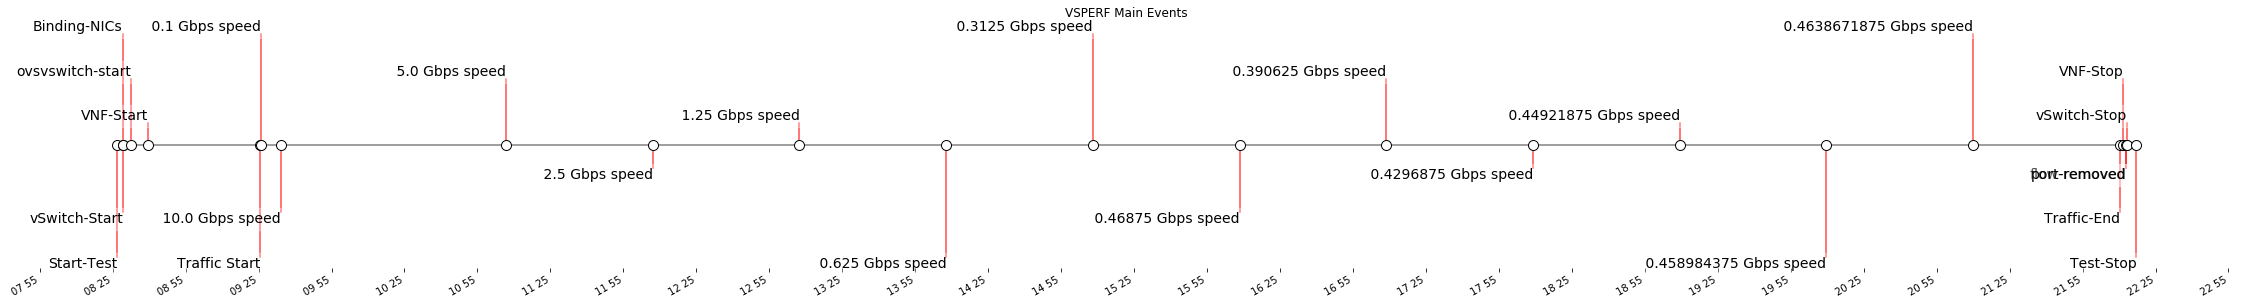

In [11]:
import matplotlib.dates as mdates
from matplotlib import ticker

levels = np.array([-5, 5, -3, 3, -1, 1])
fig, ax = plt.subplots(figsize=(40, 5))

# Create the base line
start = min(dates)
stop = max(dates)
ax.plot((start, stop), (0, 0), 'k', alpha=.5)

pos_list = np.arange(len(dates))

# Iterate through releases annotating each one
for ii, (iname, idate) in enumerate(zip(names, dates)):
    level = levels[ii % 6]
    vert = 'top' if level < 0 else 'bottom'
    ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
    # Plot a line up to the text
    ax.plot((idate, idate), (0, level), c='r', alpha=.7)
    # Give the text a faint background and align it properly
    ax.text(idate, level, iname,
            horizontalalignment='right', verticalalignment=vert, fontsize=14,
            backgroundcolor=(1., 1., 1., .3))
ax.set(title="VSPERF Main Events")
# Set the xticks formatting
# format xaxis with 1 month intervals
ax.get_xaxis().set_major_locator(mdates.SecondLocator(interval=30))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%M %S"))
#ax.get_xaxis().set_major_locator(ticker.FixedLocator((pos_list)))
#ax.get_xaxis().set_major_formatter(ticker.FixedFormatter((dates)))
fig.autofmt_xdate()

plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
          list(ax.spines.values())), visible=False)
plt.show()

## Current and old.

# Current Result

1691523.2


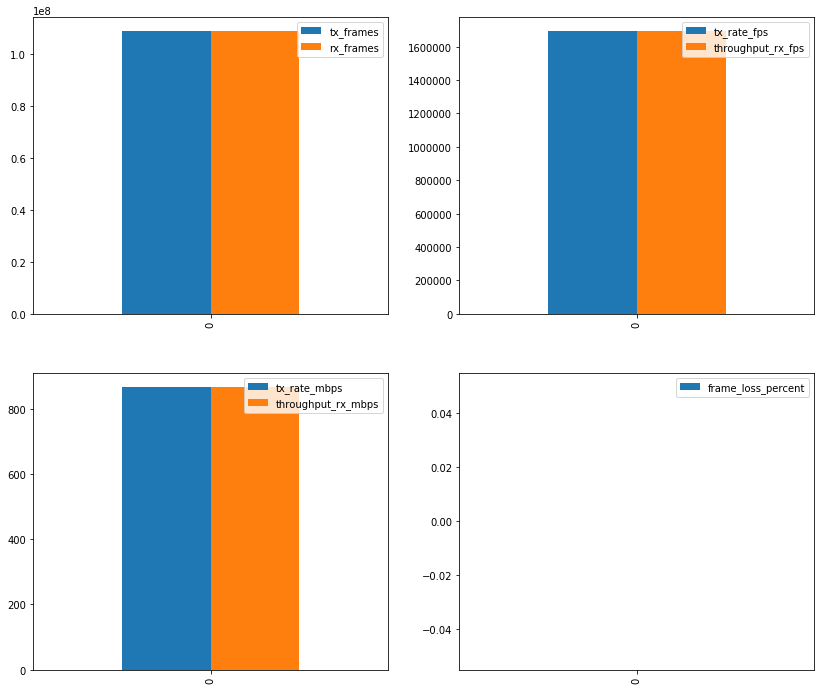

In [12]:
import glob
filename = os.path.basename(glob.glob('./results/result*.csv')[0])
filename
tdf = pd.read_csv(os.path.join('./results', filename))
pkts = ['tx_frames', 'rx_frames']
fps =  ['tx_rate_fps', 'throughput_rx_fps']
mbps = ['tx_rate_mbps', 'throughput_rx_mbps']
pcents = ['tx_rate_percent', 'throughput_rx_percent', 'frame_loss_percent']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
tdf.plot.bar(y= pkts,ax=axes[0,0])
tdf.plot.bar(y= fps,ax=axes[0,1])
tdf.plot.bar(y= mbps,ax=axes[1,0])
tdf.plot.bar(y= pcents,ax=axes[1,1])
current_pkt_size = str(tdf['packet_size'].iloc[-1])
current_rx_fps = str(tdf['throughput_rx_fps'].iloc[-1])
print(current_rx_fps)

## How Current Result compares to Previous ones?

In [14]:
import urllib
import json
import requests
#json_data = requests.get('http://testresults.opnfv.org/test/api/v1/results?project=vsperf').json()
json_data = requests.get('http://10.10.120.22:8000/api/v1/results?project=vsperf').json()
res = json_data['results']
df1 = pd.DataFrame(res)
sort_by_date = df1.sort_values('start_date')
details = df1['details'].apply(pd.Series)
details[current_pkt_size] = pd.to_numeric(pd.Series(details[current_pkt_size]))
# details.plot.bar(y = current_pkt_size)
details_cur_pkt = details[[current_pkt_size]].copy()
details_cur_pkt.loc[-1]= float(current_rx_fps)
details_cur_pkt.index = details_cur_pkt.index + 1  # shifting index
details_cur_pkt.sort_index(inplace=True) 
ax = details_cur_pkt.plot.bar()
ax.set_ylabel("Frames per sec")
ax.set_xlabel("Run Number")
def highlight(indices,ax):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor='RED', edgecolor='none', alpha=.2)
        i+=1
highlight([0], ax)

ConnectionError: HTTPConnectionPool(host='10.10.120.22', port=8000): Max retries exceeded with url: /api/v1/results?project=vsperf (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001822F7B50F0>: Failed to establish a new connection: [WinError 10065] A socket operation was attempted to an unreachable host'))

## Heatmaps

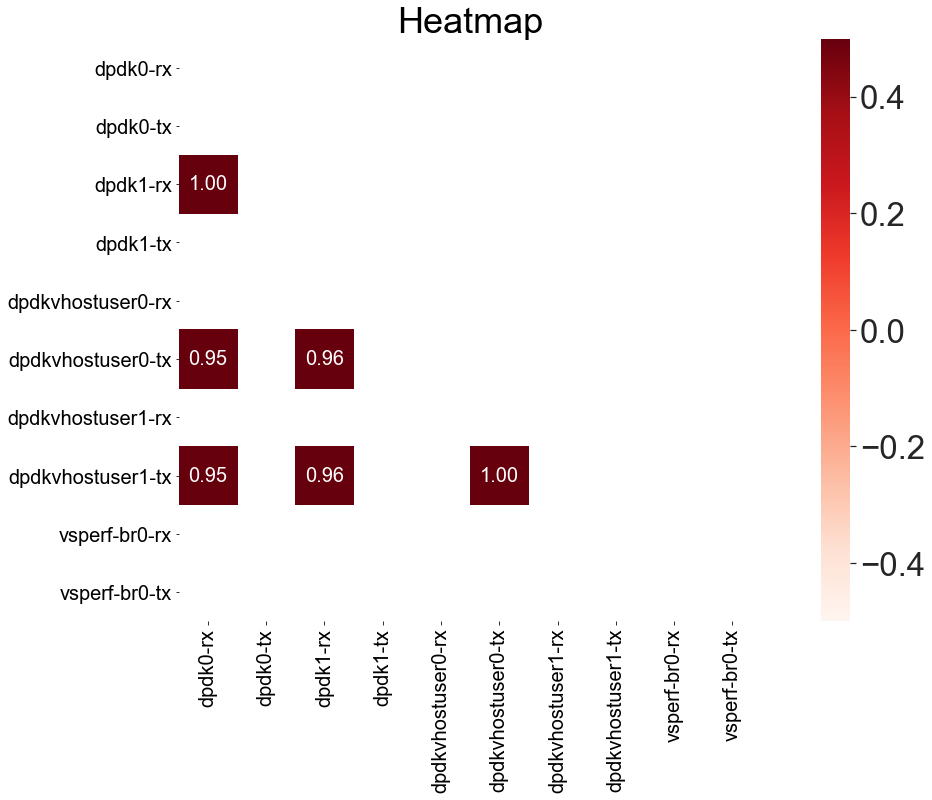

In [15]:
array_of_dfs = []
for dirs in glob.glob('./pod12-node4/ovs_stats-vsperf*'):
    dirname = os.path.basename(dirs)
    # print(dirs)
    # print(dirname)
    if dirname:
        port = dirname.split('.')[1]
        # print(port)
        if glob.glob('./pod12-node4/'+dirname+ '/*dropped*'):
            full_path = glob.glob('./pod12-node4/'+dirname+ '/*dropped*')[0]
            filename = os.path.basename(full_path)
            if filename:
                df = pd.read_csv(full_path)
                df.rename(index=str, columns={"rx": port+"-rx" , "tx": port+"-tx"}, inplace=True)
                df = df.drop(columns=['epoch'])
                array_of_dfs.append(df)
                #print(df.columns)
# print("Lets see:")
master_df = pd.concat(array_of_dfs, axis=1, sort=True)
master_df.columns

# get the correlation coefficient between the different columns
corr = master_df.iloc[:, 0:].corr()
arr_corr = corr.values
# print(arr_corr)
# mask out the top triangle
arr_corr[np.triu_indices_from(arr_corr)] = np.nan
fig, ax = plt.subplots(figsize=(18, 12))
sns.set(font_scale=3.0)
hm = sns.heatmap(arr_corr, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 20}, annot=True, 
                 square=True, cmap=plt.cm.Reds)
ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=20)

ax.set_title('Heatmap')
plt.tight_layout()
plt.show()